In [ ]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
#PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

current_version = 0 #June 23nd, 2023
current_version = 1 # July 21st 2023

stdfont = 14
stdyfrac = 0.06


In [2]:
second_rev_animals = ['AE_238','AE_239','AE_240']
animals = np.concatenate((ephys_animals,second_rev_animals))
animals = second_rev_animals

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
Fetching files for AE_301
Fetching files for AE_312
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.txt: No columns to parse from file
Error loading P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
ERROR: MULTIPLE REVERSALS IN ANIMAL BS_179
P:\Behavioor\BS_191\behavior\BS_191_1v2.txt: No columns to parse from file
Error loading P:\Behavioor\BS_33\behavior\BS_33_9v1.txt: No columns to parse from file
P:\Behavioor\BS_33\behavior\BS_33_9v1.txt: No columns to parse from file
P:\Behavioor\BS_33\behavior\BS_33_20v1_reversal.txt: No columns to parse from file
P:\Behavioor\BS_49\behavior\BS_49_14v4_reversal.txt: No columns to parse from file
Error loading P:\Behavioor\BS_87\b

there are 398 trials in AE_239 day 39
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228
there are 398 trials in AE_239 day 39


../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


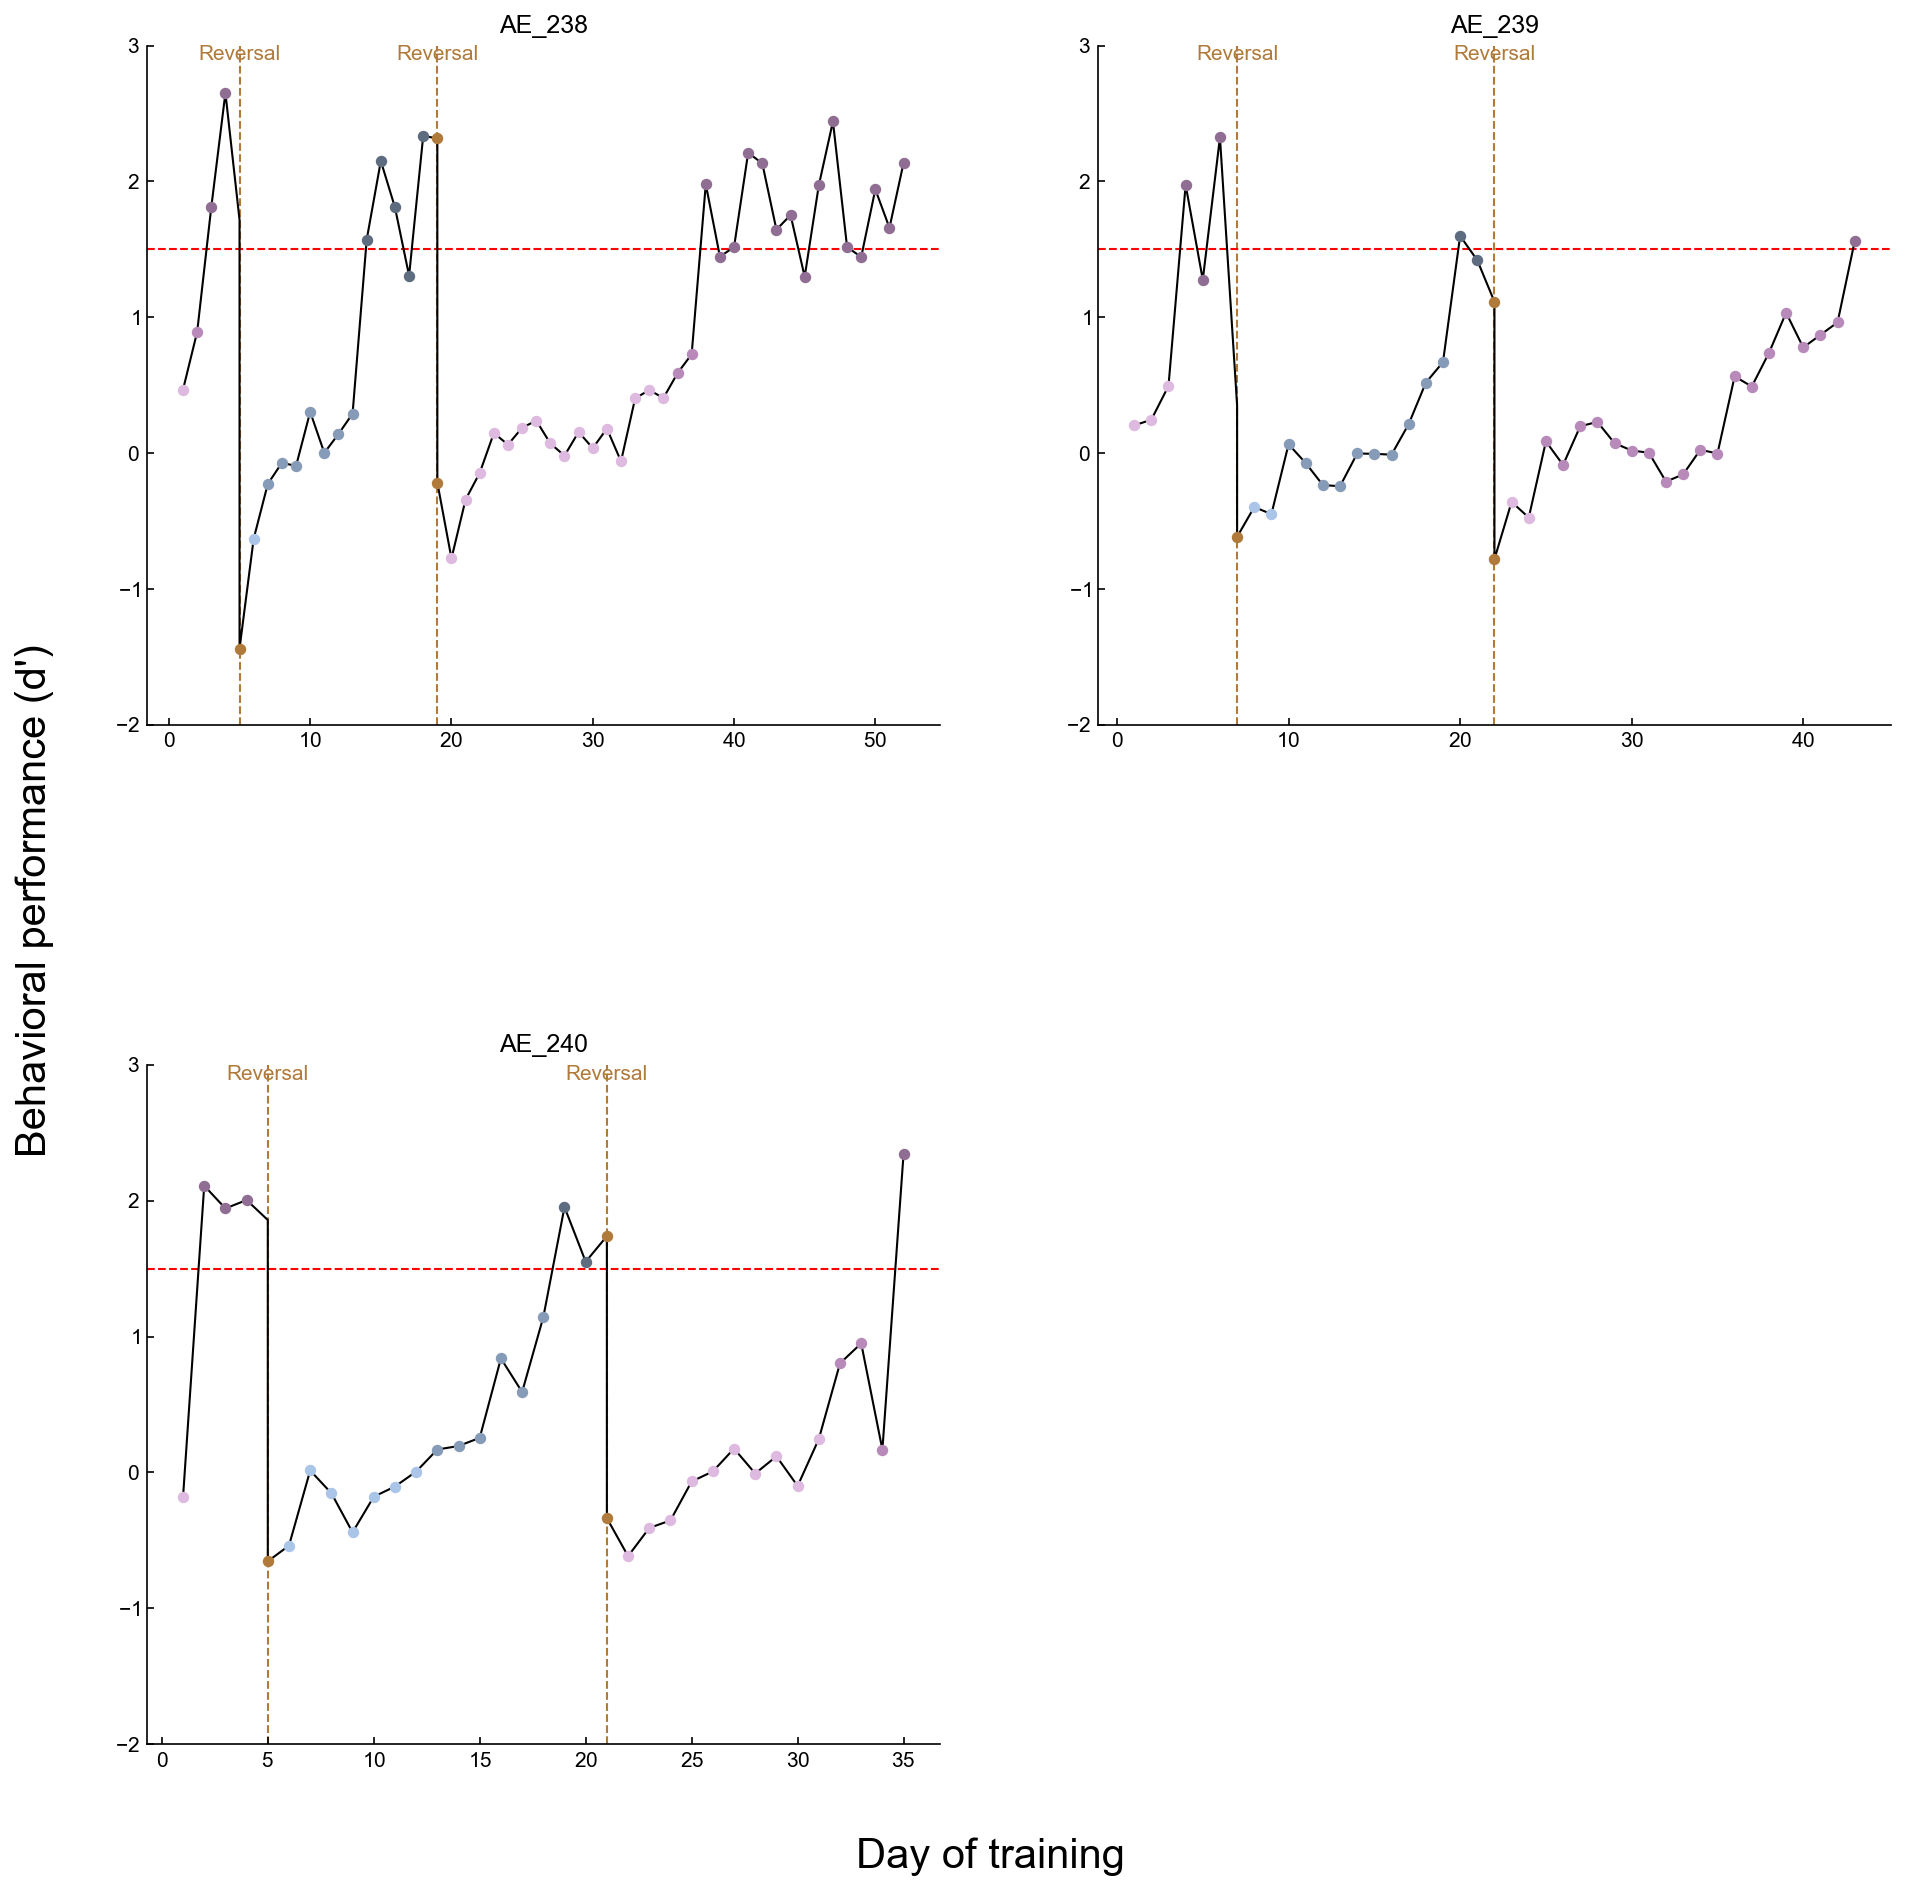

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

# Example Learning Curves

In [5]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax


In [6]:
def animal_learning_curve(animal):
    rev = animalBehaviors[animal].reversal
    max_day = np.max([s for s in animalBehaviors[animal].sessions])
    print(rev)
    print(max_day)
    

    fig,ax = make_axis_size(5, 4, left=.3, bottom=.3, right=0, top=0)
    
    PLOTTING_PHASE_COLORS = PHASE_COLORS


    reversal = animalBehaviors[animal].reversal
    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    expert_days = np.concatenate(( learning_phases[animal].pre_expert_days,learning_phases[animal].post_expert_days,learning_phases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)

    print(dp_list)

    days = np.sort(days)

    ax.plot(days,dp_list,color='k',lw=1)

    #circle_size = 60
    circle_size = 80

    #Pre Early
    pre_early = np.isin(days,learning_phases[animal].pre_early_days)
    ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

    #Pre Late
    pre_late = np.isin(days,learning_phases[animal].pre_late_days)
    ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)

    #Pre Expert
    pre_expert = np.isin(days,learning_phases[animal].pre_expert_days)
    ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

    #Post Early
    post_early = np.isin(days,learning_phases[animal].post_early_days)
    ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

    #Post Late
    post_late = np.isin(days,learning_phases[animal].post_late_days)
    ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)

    #Post Expert
    post_expert = np.isin(days,learning_phases[animal].post_expert_days)
    ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)
    
    #Second Early
    second_early = np.isin(days,learning_phases[animal].second_early_days)
    ax.scatter(days[second_early],dp_list[second_early],color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

    #Second Late
    second_late = np.isin(days,learning_phases[animal].second_late_days)
    ax.scatter(days[second_late],dp_list[second_late],color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)

    #Second Expert
    second_expert = np.isin(days,learning_phases[animal].second_expert_days)
    ax.scatter(days[second_expert],dp_list[second_expert],color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

    #Switch
    switch = np.equal(days,animalBehaviors[animal].reversal)
    ax.scatter(days[switch],dp_list[switch],color=SWITCH_COLOR,s=circle_size,zorder=10)
    
    #Switch
    second_switch = np.equal(days,animalBehaviors[animal].second_reversal)
    ax.scatter(days[second_switch],dp_list[second_switch],color=SWITCH_COLOR,s=circle_size,zorder=10)

    ax.set_ylim([-2,3])
    ax.set_yticks([-2,-1,0,1,2,3])

    ax.set_xlim([0,max_day])
    ax.set_xticks(range(1,max_day+1))
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        labeledindex = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42]
        #labeledindex = [0,2,4,6,8]
        labeledindex = [0,4,8,12,16,20,24,28,32,36,40,44,48,52,56]
        #labeledindex = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42]
        
        if index not in labeledindex:
            label.set_visible(False)
            
    ax.tick_params(length=6)

    size = 0.5
    center = np.mean(ax.get_ylim())
    ax.text(reversal,2.1,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90,fontsize=14)
    ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
    ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

    ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
    print(days)
    ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0],fontsize=14,weight='bold')
    ax.text(4,0.8,'Late',color=PLOTTING_PHASE_COLORS[1],fontsize=14,weight='bold')
    ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2],fontsize=14,weight='bold')
    ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3],fontsize=14,weight='bold')
    ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4],fontsize=14,weight='bold')
    ax.text(10,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5],fontsize=14,weight='bold')

    ax.set_ylabel("Behavioral performance (d') ")
    ax.set_xlabel('Sessions')
    ax.set_axisbelow(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    #These must be changed at the end. brokenaxes recalculates ticks for several calls
    #ax.set_xticks(range(1,max_day+2))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass
    
#     fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_19.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

5
52
[ 4.68119205e-01  8.92127039e-01  1.81043271e+00  2.65130439e+00
 -1.43746175e+00 -6.29734086e-01 -2.26296725e-01 -7.03929399e-02
 -9.38847305e-02  3.03932929e-01  2.58911330e-03  1.40758541e-01
  2.90748786e-01  1.57196501e+00  2.15031908e+00  1.80900961e+00
  1.30608648e+00  2.33542406e+00 -2.16095048e-01 -7.74286059e-01
 -3.40748795e-01 -1.44702984e-01  1.48047890e-01  6.30761146e-02
  1.87002602e-01  2.39863547e-01  7.16519154e-02 -1.82110789e-02
  1.56660462e-01  3.67329327e-02  1.81212518e-01 -5.99843541e-02
  4.03647967e-01  4.64644947e-01  4.05883503e-01  5.88896842e-01
  7.28173384e-01  1.97925343e+00  1.44655164e+00  1.51691282e+00
  2.21091884e+00  2.13223275e+00  1.64485363e+00  1.75254899e+00
  1.29830029e+00  1.97159972e+00  2.44119938e+00  1.51717144e+00
  1.44352439e+00  1.94126693e+00  1.65844612e+00  2.13674040e+00]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49

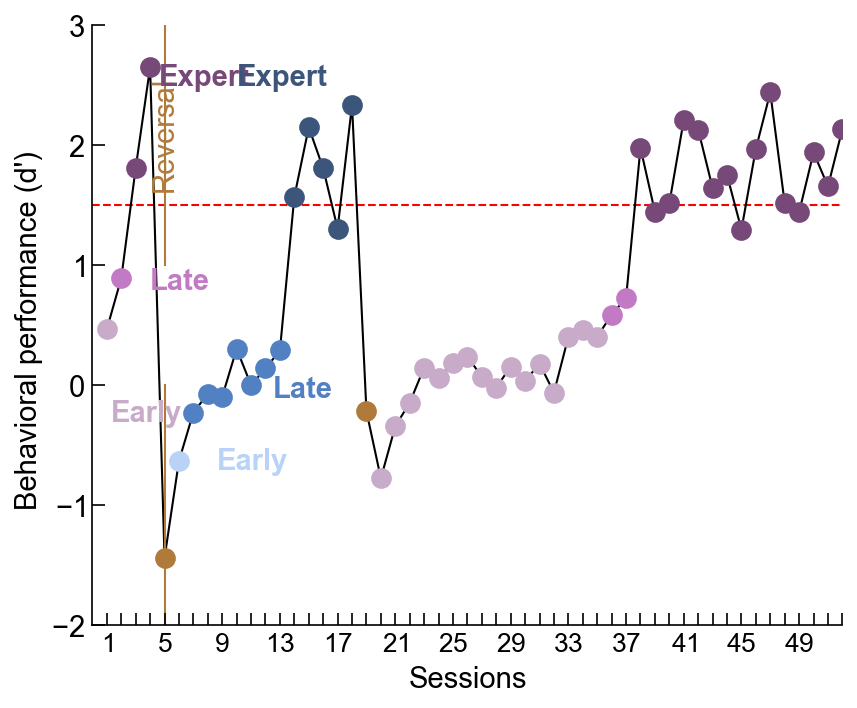

In [30]:
animal_learning_curve(second_rev_animals[0])
plt.savefig(os.path.join('D:\\TempFigures\\'+second_rev_animals[0]+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

7
43
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228
there are 398 trials in AE_239 day 39
[ 2.04280157e-01  2.46256269e-01  4.94510861e-01  1.97464318e+00
  1.27600693e+00  2.32325257e+00 -6.15749824e-01 -3.96290400e-01
 -4.48117209e-01  6.58041797e-02 -7.29536319e-02 -2.34679964e-01
 -2.42987661e-01 -2.16816302e-03 -4.50783352e-03 -1.09849398e-02
  2.13701816e-01  5.18740815e-01  6.69844636e-01  1.59902325e+00
  1.41984167e+00 -7.79491128e-01 -3.58356799e-01 -4.73742770e-01
  8.64119487e-02 -8.62754651e-02  1.98208950e-01  2.30390209e-01
  7.35185146e-02  1.97375738e-02  3.34742717e-03 -2.09098671e-01
 -1.55880600e-01  2.51311655e-02 -2.29115648e-03  5.65221337e-01
  4.90712180e-01  7.37698424e-01  1.03377029e+00  7.77932302e-01
  8.70528940e-01  9.62855505e-01  1.56100086e+00]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


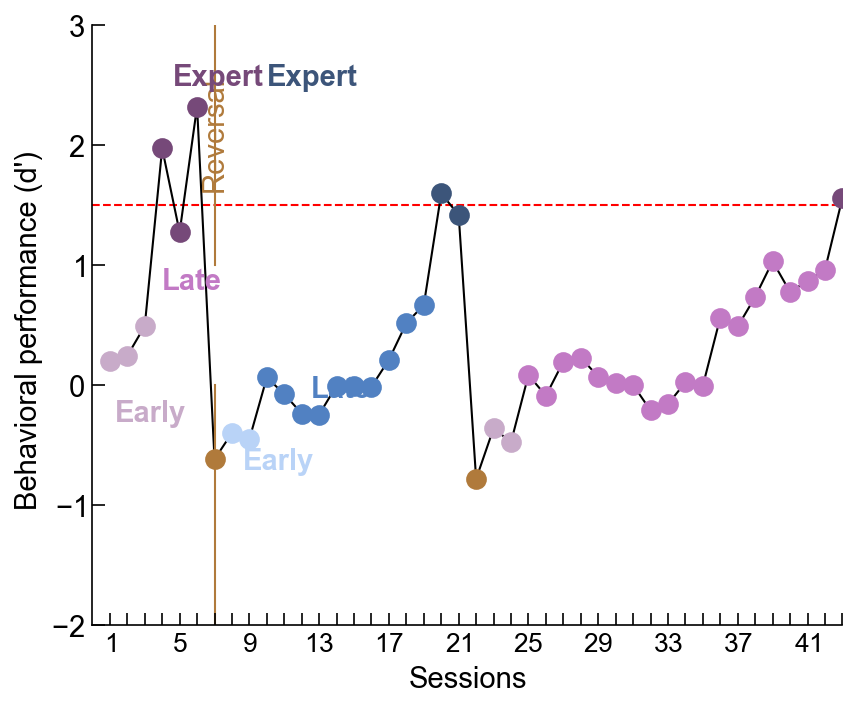

In [31]:
animal_learning_curve(second_rev_animals[1])
plt.savefig(os.path.join('D:\\TempFigures\\'+second_rev_animals[1]+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

5
35
[-0.18175009  2.10993283  1.94269549  2.00446782 -0.65392972 -0.53814964
  0.01437388 -0.15270996 -0.44038719 -0.17877328 -0.10342424  0.00628522
  0.16882538  0.19458738  0.25463549  0.8391513   0.59187932  1.14225548
  1.95286109  1.5506326  -0.33635327 -0.61592815 -0.40861208 -0.35277308
 -0.06651905  0.00739803  0.1754968  -0.00783258  0.11863461 -0.09938982
  0.24591922  0.80271061  0.95001245  0.16767118  2.34666768]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]


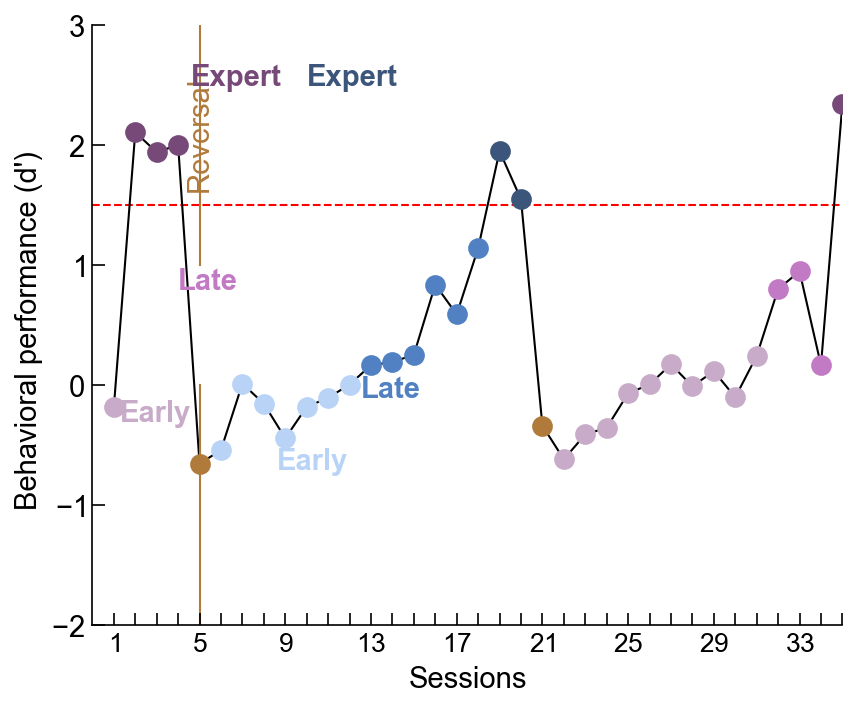

In [32]:
animal_learning_curve(second_rev_animals[2])
plt.savefig(os.path.join('D:\\TempFigures\\'+second_rev_animals[2]+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

# D' Over Learning

In [6]:
pre_early_dps = []
pre_late_dps = []
pre_expert_dps = []
post_early_dps = []
post_late_dps = []
post_expert_dps = []
second_early_dps = []
second_late_dps = []
second_expert_dps = []

for animal in tqdm(animals):
    
    reversal = np.nan
    second_reversal = np.nan

    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    if hasattr(animalBehaviors[animal],'reversal') and np.isfinite(animalBehaviors[animal].reversal):
        reversal = animalBehaviors[animal].reversal
        days.append(reversal)
    if hasattr(animalBehaviors[animal],'second_reversal') and np.isfinite(animalBehaviors[animal].second_reversal):
        second_reversal = animalBehaviors[animal].second_reversal
        days.append(second_reversal)
    days = np.sort(days)
    #Needs days
    expert_days = np.concatenate(( learning_phases[animal].pre_expert_days,learning_phases[animal].post_expert_days,learning_phases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
    this_pre_early_dps = []
    this_pre_late_dps = []
    this_pre_expert_dps = []
    this_post_early_dps = []
    this_post_late_dps = []
    this_post_expert_dps = []
    this_second_early_dps = []
    this_second_late_dps = []
    this_second_expert_dps = []
    
    for day_idx,day in enumerate(days):
        if day in learning_phases[animal].pre_early_days:
            this_pre_early_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].pre_late_days:
            this_pre_late_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].pre_expert_days:
            this_pre_expert_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].post_early_days:
            this_post_early_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].post_late_days:
            this_post_late_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].post_expert_days:
            this_post_expert_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].second_early_days:
            this_second_early_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].second_late_days:
            this_second_late_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].second_expert_days:
            this_second_expert_dps.append(dp_list[day_idx])
    
    pre_early_dps.append(np.mean(this_pre_early_dps))
    pre_late_dps.append(np.mean(this_pre_late_dps))
    pre_expert_dps.append(np.mean(this_pre_expert_dps))
    post_early_dps.append(np.mean(this_post_early_dps))
    post_late_dps.append(np.mean(this_post_late_dps))
    post_expert_dps.append(np.mean(this_post_expert_dps))
    second_early_dps.append(np.mean(this_second_early_dps))
    second_late_dps.append(np.mean(this_second_late_dps))
    second_expert_dps.append(np.mean(this_second_expert_dps))
        
    print(animal)
    print(this_post_expert_dps)
    print(this_second_expert_dps)

 33%|███▎      | 1/3 [00:00<00:00,  7.87it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 3/3 [00:00<00:00, 15.79it/s]

AE_238
[1.5719650076278666, 2.1503190763092026, 1.8090096108586824, 1.3060864812066302, 2.335424063104854]
[1.9792534327666313, 1.446551641378675, 1.5169128157121385, 2.2109188414329894, 2.1322327464250628, 1.6448536269514722, 1.7525489897520032, 1.2983002881994379, 1.971599716065015, 2.441199375711327, 1.517171439135343, 1.4435243876955408, 1.9412669326612977, 1.6584461226305085, 2.1367404021813656]
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228
there are 398 trials in AE_239 day 39
AE_239
[1.59902324595228, 1.4198416736366166]
[1.5610008558427577]
AE_240
[1.952861093106946, 1.5506325994429226]
[2.3466676756160596]


In [7]:
print(len(pre_early_dps))
print(len(pre_late_dps))
print(len(pre_expert_dps))
print(len(post_early_dps))
print(len(post_late_dps))
print(len(post_expert_dps))
print(len(second_early_dps))
print(len(second_late_dps))
print(len(second_expert_dps))

3
3
3
3
3
3
3
3
3


In [8]:
post_early_dps

[-0.6297340863028306, -0.4222038042101807, -0.19896931728112424]

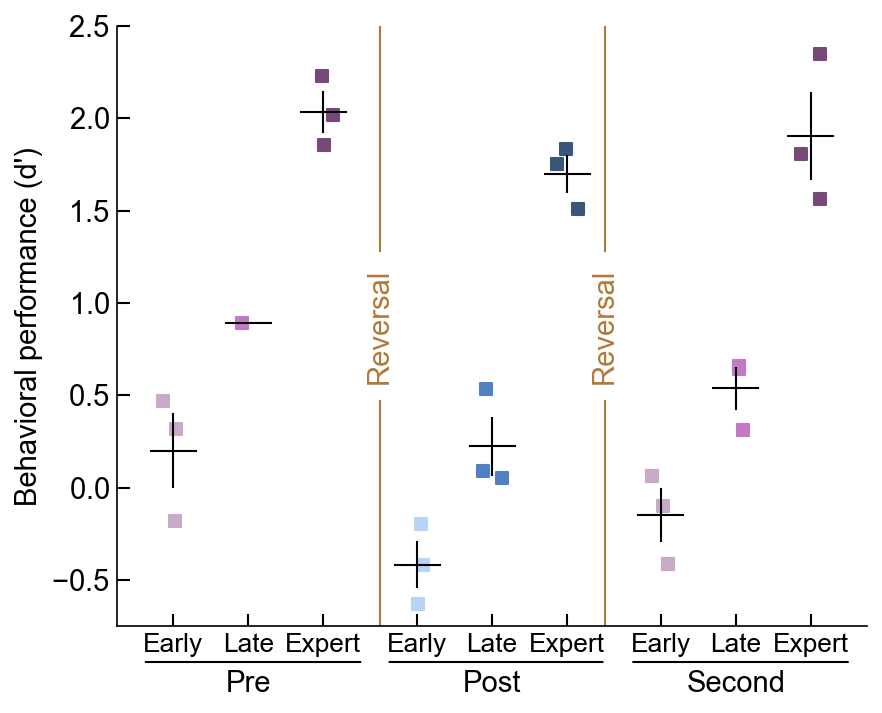

In [12]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(5, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps,second_early_dps,second_late_dps,second_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    elif idx >5:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx-6],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    else:
        ax.scatter(X+0*switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+0*switch_offset-width,idx+0*switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+0*switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.75,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,8.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+0*switch_offset,4+0*switch_offset,5+0*switch_offset,6+switch_offset,7+switch_offset,8+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
xtick_pos_second = ax.get_xticks()[7]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
t3 = ax.text(xtick_pos_second, Yval, 'Second', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0325, -stdyfrac), xycoords='axes fraction', xytext=(0.33, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.3575, -stdyfrac), xycoords='axes fraction', xytext=(0.653, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.6825, -stdyfrac), xycoords='axes fraction', xytext=(0.98, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

### Second Bar
Y = np.mean(ax.get_ylim())
t = ax.text(5.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([5.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([5.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2,t3]
fig.savefig(os.path.join('D:\\Figures\Manuscript Figures\Second reversal dp.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [9]:
print(len(pre_early_dps))
print(len(pre_late_dps))
print(len(pre_expert_dps))
print(len(post_early_dps))
print(len(post_late_dps))
print(len(post_expert_dps))
print(len(second_early_dps))
print(len(second_late_dps))
print(len(second_expert_dps))

3
3
3
3
3
3
3
3
3


In [12]:
print(f"pre early: {np.nanmean(pre_early_dps)} +/- {np.std(ilep.rmnan(pre_early_dps))}")
print(f"pre late: {np.nanmean(pre_late_dps)} +/- {np.std(ilep.rmnan(pre_late_dps))}")
print(f"pre expert: {np.nanmean(pre_expert_dps)} +/- {np.std(ilep.rmnan(pre_expert_dps))}")
print(f"post early: {np.nanmean(post_early_dps)} +/- {np.std(ilep.rmnan(post_early_dps))}")
print(f"post late: {np.nanmean(post_late_dps)} +/- {np.std(ilep.rmnan(post_late_dps))}")
print(f"post expert: {np.nanmean(post_expert_dps)} +/- {np.std(ilep.rmnan(post_expert_dps))}")
print(f"second early: {np.nanmean(second_early_dps)} +/- {np.std(ilep.rmnan(second_early_dps))}")
print(f"second late: {np.nanmean(second_late_dps)} +/- {np.std(ilep.rmnan(second_late_dps))}")
print(f"second expert: {np.nanmean(second_expert_dps)} +/- {np.std(ilep.rmnan(second_expert_dps))}")

pre early: 0.2004616258105806 +/- 0.2773980450004368
pre late: 0.8921270393443941 +/- 0.0
pre expert: 2.035956052162359 +/- 0.15270582356277135
post early: -0.41696906926471183 +/- 0.17589793137885956
post late: 0.2238354689199784 +/- 0.21844858942282058
post expert: 1.6985800512969433 +/- 0.1379544568361422
second early: -0.15087656604321845 +/- 0.1991200958343533
second late: 0.5369984514369884 +/- 0.15904298042810974
second expert: 1.9045899717906902 +/- 0.3282205451417711


In [11]:
# Not all animals have every phase for pre and post. For this reason it's best to run an unpaired parametric test since
# We want to use all of the data

A1 = ilep.rmnan(pre_early_dps)
B1 = ilep.rmnan(pre_late_dps)
C1 = ilep.rmnan(pre_expert_dps)

A2 = ilep.rmnan(post_early_dps)
B2 = ilep.rmnan(post_late_dps)
C2 = ilep.rmnan(post_expert_dps)

A3 = ilep.rmnan(second_early_dps)
B3 = ilep.rmnan(second_late_dps)
C3 = ilep.rmnan(second_expert_dps)

print(len(A1))
print(len(B1))
print(len(C1))
print(len(A2))
print(len(B2))
print(len(C2))
print(len(A3))
print(len(B3))
print(len(C3))

ps = []

X,Y = (A1,B1)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B1,C1)
ps.append(ttest_ind(X,Y).pvalue)

X,Y = (A2,B2)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B2,C2)
ps.append(ttest_ind(X,Y).pvalue)

X,Y = (A3,B3)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B3,C3)
ps.append(ttest_ind(X,Y).pvalue)

_,ps = pg.multicomp(ps,method='fdr_bh')
print(ps)

3
1
3
3
3
3
3
3
3
[       nan        nan 0.03193914 0.00511715 0.02509568 0.01215112]


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [89]:
Data = SimpleNamespace()
Data.preearly = ilep.rmnan(second_early_dps)
Data.prelate = ilep.rmnan(second_late_dps)
Data.preexpert = ilep.rmnan(second_expert_dps)
Data.postearly = post_early_dps
Data.postlate = post_late_dps
Data.postexpert = post_expert_dps
ilep.nonparametricIndependentStatsCompareToOwnEarly(Data)

            Source         SS    DF         MS           F         p-unc  \
0            phase  10.325853   3.0   3.441951   53.498524  5.553556e-18   
1          context  35.635046   1.0  35.635046  553.878379  1.094105e-34   
2  phase * context  10.019888   3.0   3.339963   51.913307  1.138705e-17   
3         Residual   4.439274  69.0   0.064337         NaN           NaN   

        np2  
0  0.699341  
1  0.889224  
2  0.692978  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000001  0.000004 -8.257995
8     post-late  baseline  experimental  0.000005  0.000009 -2.376791
9    pre-expert  baseline  experimental  0.100000  0.100000 -4.946000
10     pre-late  baseline  experimental  0.100000  0.100000 -2.493453
key preearly has 3 non-nan elements
key prelate has 3 non-nan elements
key preexpert has 3 non-nan elements
key postearly has 16 non-nan elements
key postlate has 16 non-nan elements
key postexpert 

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,678.0,two-sided,4.975995e-02,0.298560,fdr_bh,0.915106
1,phase,-,post-expert,pre-expert,False,False,96.0,two-sided,9.244782e-01,0.924478,fdr_bh,-0.021877
2,phase,-,post-expert,pre-late,False,False,122.0,two-sided,3.906906e-01,0.684964,fdr_bh,0.634818
3,phase,-,post-late,pre-expert,False,False,65.0,two-sided,2.285443e-01,0.684964,fdr_bh,-1.341925
4,phase,-,post-late,pre-late,False,False,81.0,two-sided,5.708034e-01,0.684964,fdr_bh,-0.242821
5,phase,-,pre-expert,pre-late,False,False,22.5,two-sided,5.196412e-01,0.684964,fdr_bh,0.720057
6,context,-,baseline,experimental,False,False,18.0,two-sided,1.808187e-13,NaN,NaN,-2.359317
7,phase * context,post-expert,baseline,experimental,False,False,0.0,two-sided,1.055661e-06,0.000004,fdr_bh,-8.257995
8,phase * context,post-late,baseline,experimental,False,False,6.0,two-sided,4.667498e-06,0.000009,fdr_bh,-2.376791
9,phase * context,pre-expert,baseline,experimental,False,False,0.0,two-sided,1.000000e-01,0.100000,fdr_bh,-4.946000
